### Using smartphone accelerometers and gyroscopes time series data for activity classification

The use case here is classifying Human Activity Recognition (HAR) using windowed time series data collected from accelerometers and gyroscopes of a smartphone. 

### Dataset

Human Activity Recognition database built from the recordings of 30 subjects performing activities of daily living (ADL) while carrying a waist-mounted smartphone with embedded inertial sensors: accelerometers and gyroscoped (accelerometers measure linear accelerations, gyros give the rotational/angular velocities).

The data is from experiments carried out with a group of 30 volunteers within an age bracket of 19-48 years. Each person performed six activities (WALKING, WALKING_UPSTAIRS, WALKING_DOWNSTAIRS, SITTING, STANDING, LAYING) wearing a smartphone (Samsung Galaxy S II) on the waist. Using its embedded accelerometer and gyroscope, 3-axial linear acceleration and 3-axial angular velocity were captured at a constant rate of 50Hz. 

The obtained dataset has been randomly partitioned into two sets, where 70% of the volunteers was selected for generating the training data and 30% the test data.

The sensor signals (accelerometer and gyroscope) were pre-processed by applying noise filters and then sampled in fixed-width sliding windows of 2.56 sec and 50% overlap (thus 128 readings/window). The sensor acceleration signal, which has gravitational and body motion components, was separated using a Butterworth low-pass filter into body acceleration and gravity. The gravitational force is assumed to have only low frequency components, therefore a filter with 0.3 Hz cutoff frequency was used. From each window, a vector of features was obtained by calculating variables from the time and frequency domain.

So, in a nutshell, the data contains 9 different variables:
 - total acceleration (in 3 directions/axes)
 - body acceleration (in 3 directions/axes)
 - body gyroscope (in 3 directions/axes)

Each with a measured value every 0.05s. The data is split into windows of 2.56s, and these are the input data samples. So, each input data sample is of shape (128, 9), i.e. 128 "time steps" for 9 variables.

For more detailed dataset description, see [here](https://archive.ics.uci.edu/ml/datasets/human+activity+recognition+using+smartphones).

### Task

The measurement data, i.e. each window of 2.56s with 9 variables, need to be mapped into 6 different basic activities (Walking, Walking Upstairs, Walking Downstairs, Sitting, Standing, Laying).


### Approach

Traditionally, the approach for HAR has been heavy on feature engineering. Here I apply deep learning for the task, with minimal feature engineering.




## Download the dataset and unzip

In [1]:
DATASET_URL = r"https://archive.ics.uci.edu/ml/machine-learning-databases/00240/UCI%20HAR%20Dataset.zip"

In [2]:
!pwd && ls

/content
sample_data


In [3]:
!mkdir HAR_data && wget $DATASET_URL

--2021-12-28 18:19:31--  https://archive.ics.uci.edu/ml/machine-learning-databases/00240/UCI%20HAR%20Dataset.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 60999314 (58M) [application/x-httpd-php]
Saving to: ‘UCI HAR Dataset.zip’

UCI HAR Dataset.zip 100%[===================>]  58.17M  40.7MB/s    in 1.4s    

2021-12-28 18:19:33 (40.7 MB/s) - ‘UCI HAR Dataset.zip’ saved [60999314/60999314]



In [4]:
%cd /content

/content


In [5]:
!ls -l

total 59580
drwxr-xr-x 2 root root     4096 Dec 28 18:19  HAR_data
drwxr-xr-x 1 root root     4096 Dec  3 14:33  sample_data
-rw-r--r-- 1 root root 60999314 Feb 16  2015 'UCI HAR Dataset.zip'


In [6]:
!unzip -q 'UCI HAR Dataset.zip' -d HAR_data

In [7]:
%cd HAR_data 

/content/HAR_data


In [8]:
!ls -l

total 8
drwxrwxr-x 3 root root 4096 Feb 16  2015  __MACOSX
drwxr-xr-x 4 root root 4096 Feb 16  2015 'UCI HAR Dataset'


In [9]:
%cd UCI HAR Dataset

/content/HAR_data/UCI HAR Dataset


In [10]:
!cat activity_labels.txt

1 WALKING
2 WALKING_UPSTAIRS
3 WALKING_DOWNSTAIRS
4 SITTING
5 STANDING
6 LAYING


In [11]:
# Signals are stored here (test files in separate folder):

In [12]:
!ls -l 'train/Inertial Signals'

total 132480
-rwxr-xr-x 1 root root 15071600 Nov 29  2012 body_acc_x_train.txt
-rwxr-xr-x 1 root root 15071600 Nov 29  2012 body_acc_y_train.txt
-rwxr-xr-x 1 root root 15071600 Nov 29  2012 body_acc_z_train.txt
-rwxr-xr-x 1 root root 15071600 Nov 29  2012 body_gyro_x_train.txt
-rwxr-xr-x 1 root root 15071600 Nov 29  2012 body_gyro_y_train.txt
-rwxr-xr-x 1 root root 15071600 Nov 29  2012 body_gyro_z_train.txt
-rwxr-xr-x 1 root root 15071600 Nov 29  2012 total_acc_x_train.txt
-rwxr-xr-x 1 root root 15071600 Nov 29  2012 total_acc_y_train.txt
-rwxr-xr-x 1 root root 15071600 Nov 29  2012 total_acc_z_train.txt


In [81]:
# imports
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow.keras as keras
import os

import matplotlib.pyplot as plt
import seaborn as sns

from pathlib import Path
from typing import List
from sklearn.metrics import confusion_matrix


In [14]:
DATA_BASE_PATH = Path(r"/content/HAR_data/UCI HAR Dataset/")

In [15]:
os.listdir(DATA_BASE_PATH / "train/Inertial Signals")

['total_acc_z_train.txt',
 'body_acc_y_train.txt',
 'body_acc_z_train.txt',
 'body_gyro_y_train.txt',
 'total_acc_y_train.txt',
 'body_acc_x_train.txt',
 'body_gyro_x_train.txt',
 'body_gyro_z_train.txt',
 'total_acc_x_train.txt']

## Load the data

In [16]:
def load_file(filepath: str) -> np.array:
  """Loads a csv-like file, returns the values as a numpy array"""
  return pd.read_csv(filepath, delim_whitespace=True, header=None).values


There are 3 signal types in the raw data: total acceleration, body acceleration, and body gyroscope. Each with 3 axes of data.
--> nine variables

Each series has been partitioned into overlapping windows of 2.56 seconds of data, or 128 time steps.

Hence one sample/"row" of data has (128 * 9) elements.



In [17]:
os.listdir(DATA_BASE_PATH)

['features.txt',
 'README.txt',
 '.DS_Store',
 'activity_labels.txt',
 'train',
 'features_info.txt',
 'test']

In [18]:
# read in activity (y) labels, create mappings between indices and labels
with open(DATA_BASE_PATH / "activity_labels.txt") as f:
  y_labels = [line.rstrip("\n").split() for line in f.readlines()]

y_idx_to_label = {int(lst[0]) - 1: lst[1] for lst in y_labels}
y_label_to_idx = {label: idx for idx, label in y_idx_to_label.items()}

y_idx_to_label

{0: 'WALKING',
 1: 'WALKING_UPSTAIRS',
 2: 'WALKING_DOWNSTAIRS',
 3: 'SITTING',
 4: 'STANDING',
 5: 'LAYING'}

In [20]:
[fp.name.rstrip("train.txt").rstrip("_") for fp in sorted(list((DATA_BASE_PATH / "train/Inertial Signals").glob("*.txt")))]
# there is something weird with the rstrip and underscores, so I am stripping the "_" in a separate chained step

['body_acc_x',
 'body_acc_y',
 'body_acc_z',
 'body_gyro_x',
 'body_gyro_y',
 'body_gyro_z',
 'total_acc_x',
 'total_acc_y',
 'total_acc_z']

In [21]:
def load_dataset(data_base_path: Path):
  """data_base_path is a Path object pointing to the folder containing train and test folders.
  This is to be fed into LSTM model that expects three-dimensional input with dims of [samples, timesteps, feats].
  
  Returns np.arrays: X_train, X_test, y_train, y_test (numpy a)
  variable_names: list. In the order of how they are in X arrays
  """

  train_x_files = sorted(list((data_base_path / "train/Inertial Signals").glob("*.txt")))
  test_x_files = sorted(list((data_base_path / "test/Inertial Signals").glob("*.txt")))

  assert [f.name.replace("_train", "") for f in train_x_files] == [f.name.replace("_test", "") for f in test_x_files]

  # sanity check                
  assert len(train_x_files) == len(test_x_files) == 9

  # get variable names
  variable_names = [filepath.name.rstrip("train.txt").rstrip("_") for filepath in train_x_files]

  # Load X_train and X_test
  loaded = []
  for filepath in train_x_files:
    loaded.append(load_file(filepath))
  X_train = np.dstack(loaded)  # stack arrays in seq along 3rd axis
  assert X_train.shape[1] == 128
  assert X_train.shape[2] == 9

  # Load test files
  loaded = []
  for filepath in test_x_files:
    loaded.append(load_file(filepath))
  X_test = np.dstack(loaded)
  assert X_test.shape[1] == 128
  assert X_test.shape[2] == 9

  # load y_train and y_test
  y_train = load_file(data_base_path / "train/y_train.txt")
  y_test = load_file(data_base_path / "test/y_test.txt")
  assert y_train.shape[0] == X_train.shape[0]
  assert y_test.shape[0] == X_test.shape[0]


  # offset by one. For to_categorical, it assumes y goes from 0 to num_classes-1
  y_train =  y_train - 1
  y_test = y_test - 1

  # One hot encode
  y_train = keras.utils.to_categorical(y_train)
  y_test = keras.utils.to_categorical(y_test)
  assert y_train.shape[1] == y_test.shape[1] == 6  # six different categories
  assert all(y_train.sum(axis=1) == 1)
  assert all(y_test.sum(axis=1) == 1)
  
  return X_train, X_test, y_train, y_test, variable_names


In [22]:
X_train, X_test, y_train, y_test, variable_names = load_dataset(DATA_BASE_PATH)

In [23]:
assert np.isnan(X_train).sum() == np.isnan(X_test).sum() == 0

## Check the data

In [36]:
y_train  # one-hot encoded

array([[0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1., 0.],
       ...,
       [0., 1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0.]], dtype=float32)

In [37]:
y_train_labels = np.vectorize(y_idx_to_label.get)(y_train.argmax(axis=1))
y_train_labels[:5]

array(['STANDING', 'STANDING', 'STANDING', 'STANDING', 'STANDING'],
      dtype='<U18')

[('WALKING', 1226), ('WALKING_UPSTAIRS', 1073), ('WALKING_DOWNSTAIRS', 986), ('SITTING', 1286), ('STANDING', 1374), ('LAYING', 1407)] 



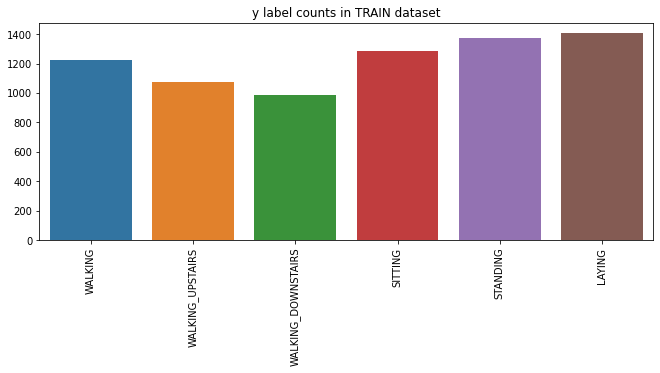

In [38]:
# Value counts for TRAIN
unique_y_vals, y_counts = np.unique(y_train.argmax(axis=1), return_counts=True)
unique_y_vals = [y_idx_to_label[idx] for idx in unique_y_vals]
print(list(zip(unique_y_vals, y_counts)), "\n")

plt.figure(figsize=(11,4))
sns.barplot(x=unique_y_vals, y=y_counts)
plt.xticks(rotation=90);
plt.title("y label counts in TRAIN dataset");

[('WALKING', 496), ('WALKING_UPSTAIRS', 471), ('WALKING_DOWNSTAIRS', 420), ('SITTING', 491), ('STANDING', 532), ('LAYING', 537)] 



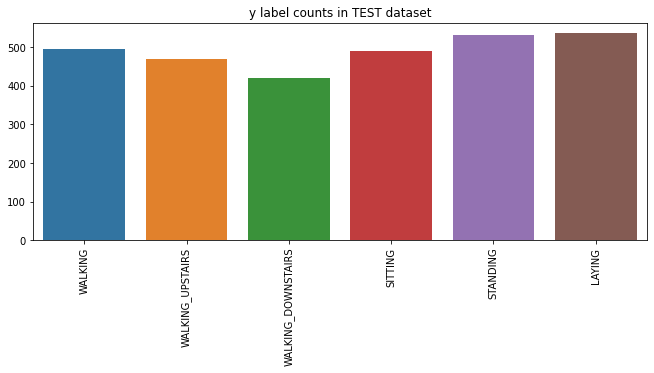

In [39]:
# Value counts for TEST
unique_y_vals, y_counts = np.unique(y_test.argmax(axis=1), return_counts=True)
unique_y_vals = [y_idx_to_label[idx] for idx in unique_y_vals]
print(list(zip(unique_y_vals, y_counts)), "\n")

plt.figure(figsize=(11,4))
sns.barplot(x=unique_y_vals, y=y_counts)
plt.xticks(rotation=90);
plt.title("y label counts in TEST dataset");

Target categories are roughly balanced, and similarly distributed in TRAIN and TEST.

In [40]:
def plot_sample(X: np.array, 
                y_labels: np.array, 
                sample_idx: int, 
                variable_names: List[str]) -> None:
  """ Plot  measurement time series for a specific sample index in X"""

  _, n_timesteps, n_variables = X.shape

  plt.figure(figsize=(14,7))

  for var_idx in range(n_variables):
    sns.lineplot(x=range(n_timesteps), y=X[sample_idx, :, var_idx], label=variable_names[var_idx])

  plt.title(f"Activity: {y_labels[sample_idx]}\n(2.56 sec window)");
  plt.legend(loc="best");
  plt.xlabel("Timestep");


Plot the time series for some randomly picked X samples for the different activities:

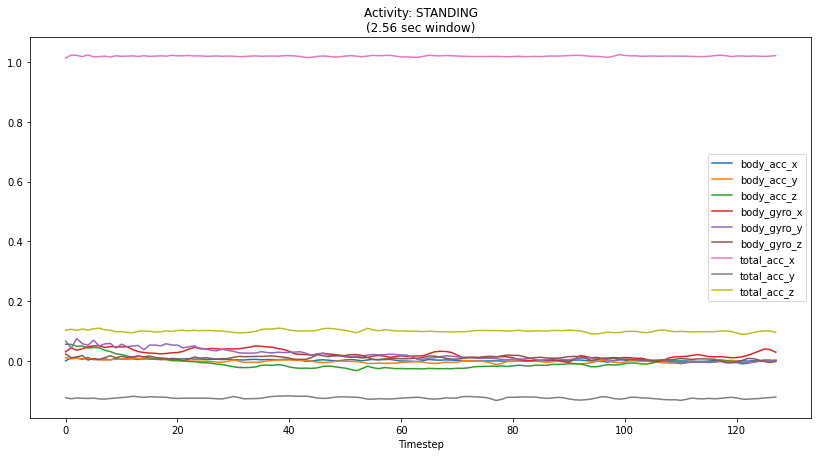

In [41]:
plot_sample(X_train, y_train_labels, 0, variable_names)

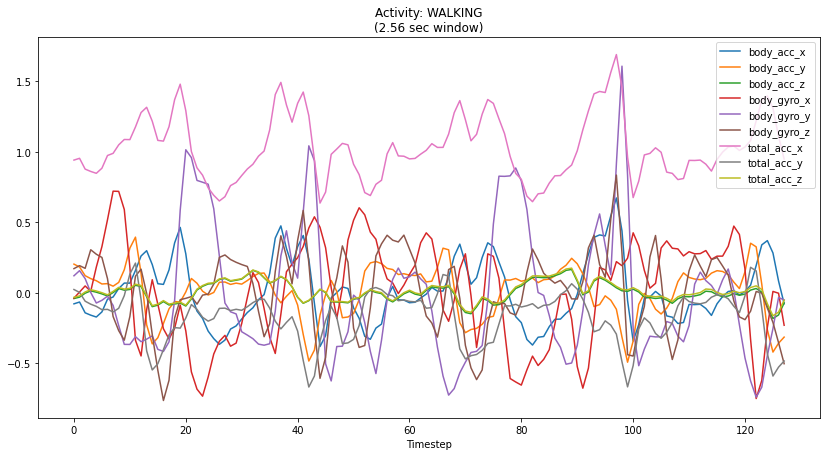

In [42]:
plot_sample(X_train, y_train_labels, 1100, variable_names)

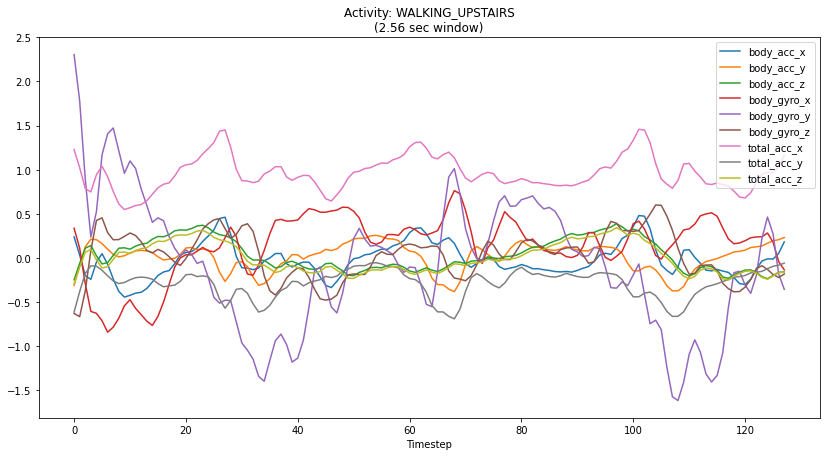

In [43]:
plot_sample(X_train, y_train_labels, 155, variable_names)

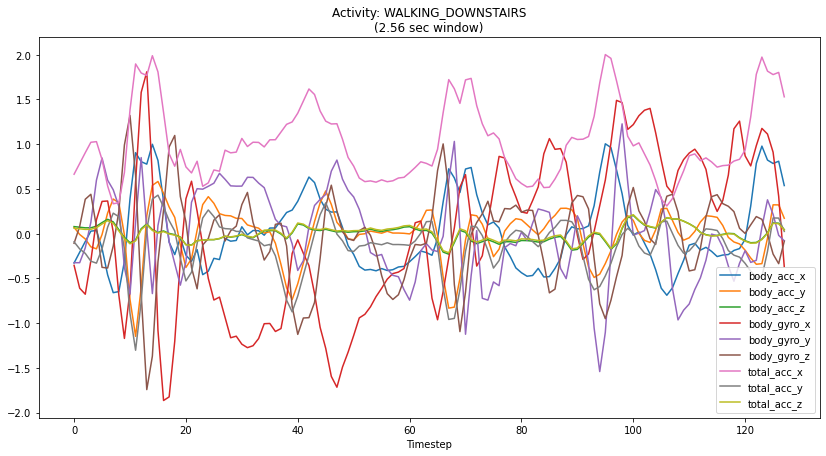

In [44]:
plot_sample(X_train, y_train_labels, 1111, variable_names)

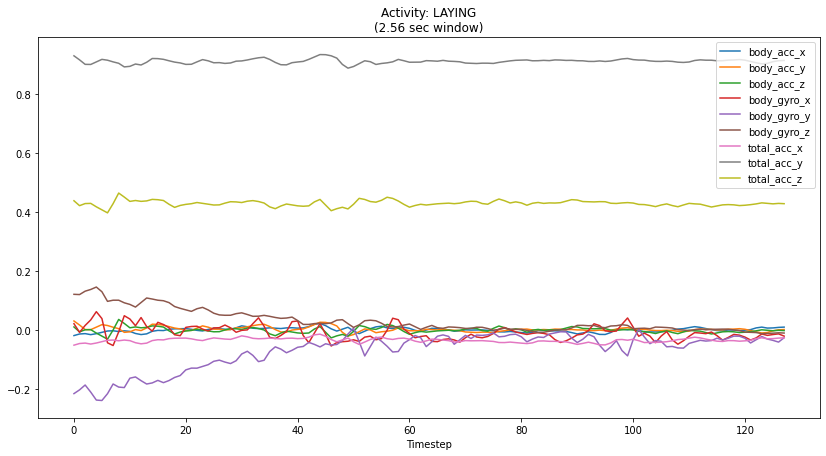

In [45]:
plot_sample(X_train, y_train_labels, 1212, variable_names)

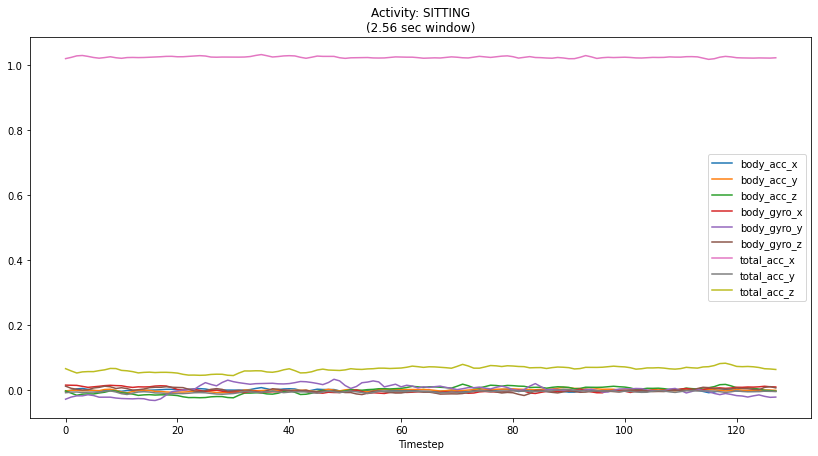

In [46]:
plot_sample(X_train, y_train_labels, 1511, variable_names)

Measurements seem reasonable, in big picture as could be expected.

Verify next how the measurement values are distributed: should the data be transformed (scaled: normalized standardized) or not.

LSTM "expects" the data be normalized: basically small-ish values, limited distribution (unscaled "all over the place" data --> may be slower to train and have poorer convergence)

In [47]:
# Overall:
(np.mean(X_train), np.std(X_train)), (np.mean(X_test), np.std(X_test))
# seems good enough, so let's skip 

((0.10206605723804434, 0.4021651763827929),
 (0.09913989069610848, 0.39567084061541474))

In [48]:
# Column (measurement) wise
np.mean(X_train, axis=(0,1)), np.std(X_train, axis=(0,1)), np.mean(X_test, axis=(0,1)), np.std(X_test, axis=(0,1))

# Looks to be good enough

(array([-6.36303058e-04, -2.92296856e-04, -2.75299412e-04,  5.06464674e-04,
        -8.23780831e-04,  1.12948439e-04,  8.04749279e-01,  2.87554865e-02,
         8.64980163e-02]),
 array([0.19484634, 0.12242748, 0.10687881, 0.40681506, 0.38185432,
        0.25574314, 0.41411195, 0.39099543, 0.35776881]),
 array([-7.37753340e-04, -3.80400759e-04, -2.59518236e-05, -1.31850896e-02,
         1.45540087e-03,  2.84960902e-03,  8.17263303e-01,  4.34935093e-03,
         8.06705481e-02]),
 array([0.18430972, 0.12060285, 0.0955351 , 0.3965164 , 0.34044524,
        0.24941602, 0.4065126 , 0.41204052, 0.3079252 ]))

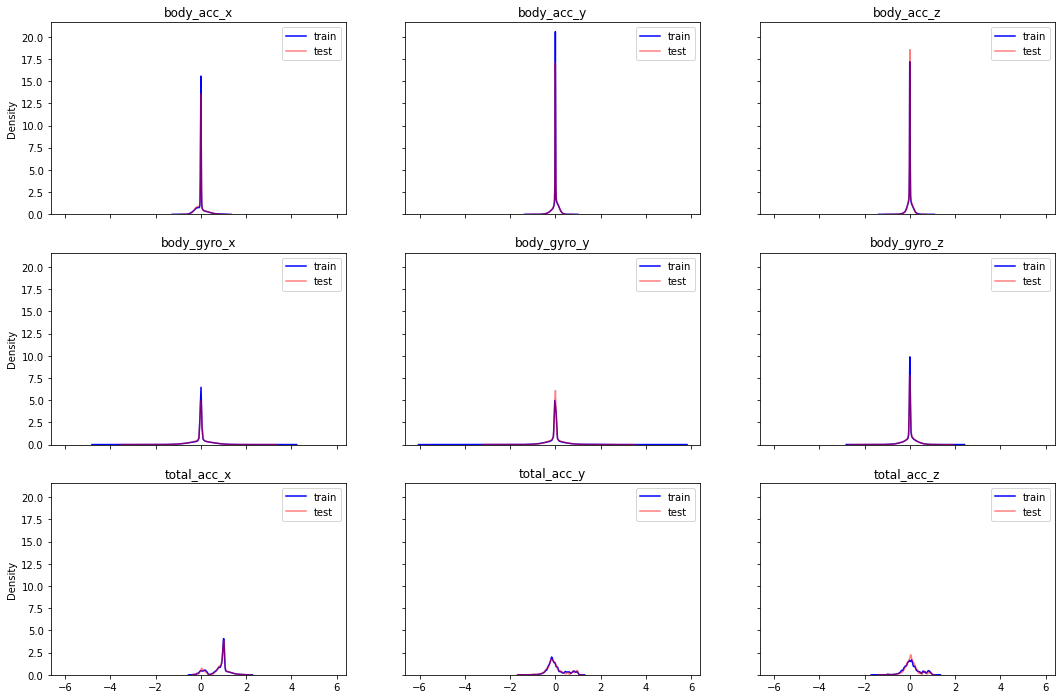

In [49]:
f, axes = plt.subplots(3, 3, sharey=True, sharex=True, figsize=(18,12));

for c in range(9):
  axis = axes[c//3, c%3]
  sns.kdeplot(x=X_train[:,:,c].flatten(), ax=axis, label="train", color="blue");
  sns.kdeplot(x=X_test[:,:,c].flatten(), ax=axis, label="test", color="red", alpha=0.5);
  axis.set_title(variable_names[c])
  axis.legend()


In [50]:
(np.min(X_train), np.max(X_train)), (np.min(X_test), np.max(X_test))


((-5.97433, 5.746062), (-3.4317010000000003, 3.468111))

Okay, looks good enough. Lets skip further preprocessing of X series.

## Create and train a model

In [24]:
# Flag for whether to training specific models multiple time, for comparison
DO_EXPERIMENTS = False

In [25]:
def plot_training_graphs(history) -> None:
  """plots train and val losses and accuracies by epoch"""

  plt.figure(figsize=(10,5))

  plt.plot(np.array(history.history['loss']), "r--", label = "Train loss")
  plt.plot(np.array(history.history['accuracy']), "g--", label = "Train accuracy")

  if 'val_loss' in history.history:
    plt.plot(np.array(history.history['val_loss']), "r-", label = "Validation loss")
    plt.plot(np.array(history.history['val_accuracy']), "g-", label = "Validation accuracy")
  
  plt.title("Training session's progress over iterations")
  plt.legend(loc='best')
  
  plt.ylabel('Training Progress (Loss/Accuracy)')
  plt.xlabel('Epoch')
  
  plt.ylim(0) 
  plt.show()

In [26]:
# Get the needed "dimensions"
n_timesteps, n_features, n_classes = X_train.shape[1], X_train.shape[2], y_train.shape[1]
print(n_timesteps, n_features, n_classes)


128 9 6


In [27]:
def build_and_test_lstm_model(x_train, y_train, x_test, y_test, epochs, batch_sz,
                              seed, verbose=0):
  """For multiple run purposes. Create a simple LSTM and train + validate it"""
  # set seeds
  np.random.seed(seed)                                                   
  tf.random.set_seed(seed)

  n_timesteps, n_features, n_classes = x_train.shape[1], x_train.shape[2], y_train.shape[1]

  model = keras.models.Sequential(
    [
     keras.layers.LSTM(units=128, input_shape=(n_timesteps, n_features),
                       bias_regularizer=keras.regularizers.l2(0.01), 
                       activity_regularizer=keras.regularizers.l2(0.01)),
     keras.layers.Dropout(rate=0.55),
     keras.layers.Dense(units=100, activation="relu"),
     keras.layers.Dense(units=n_classes, activation="softmax")
    ]
  )

  # multiclass classification --> categorical crossentropy as the loss func
  model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

  # fit the model
  history = model.fit(x_train, y_train, 
                      epochs=epochs, 
                      batch_size=batch_sz, 
                      #validation_split=0.2,
                      verbose=verbose) # , validation_data=(X_valid, y_valid)

  # evaluate model on test set
  #print("\nEvaluation on test set:")
  test_loss, test_accuracy = model.evaluate(x_test, y_test, batch_size=BATCH_SZ)

  return test_accuracy



def build_and_test_bidirectional_lstm_model(x_train, y_train, x_test, y_test, 
                                              epochs, batch_sz, seed, verbose=0):
  """For multiple run purposes. Create a simple bidirectional LSTM and train + validate it"""
  
  np.random.seed(seed)                                                   
  tf.random.set_seed(seed)

  n_timesteps, n_features, n_classes = x_train.shape[1], x_train.shape[2], y_train.shape[1]

  model = keras.models.Sequential(
    [
     keras.layers.Bidirectional(
         keras.layers.LSTM(units=128, input_shape=(n_timesteps, n_features),
                       bias_regularizer=keras.regularizers.l2(0.01), 
                       activity_regularizer=keras.regularizers.l2(0.01))
     ),
     keras.layers.Dropout(rate=0.55),
     keras.layers.Dense(units=100, activation="relu"),
     keras.layers.Dense(units=n_classes, activation="softmax")
    ]
  )

  # multiclass classification --> categorical crossentropy as the loss func
  model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

  # fit the model
  history = model.fit(x_train, y_train, 
                      epochs=epochs, 
                      batch_size=batch_sz, 
                      #validation_split=0.2,
                      verbose=verbose) # , validation_data=(X_valid, y_valid)

  # evaluate model on test set
  #print("\nEvaluation on test set:")
  test_loss, test_accuracy = model.evaluate(x_test, y_test, batch_size=BATCH_SZ)

  return test_accuracy


Lets try some different LSTM models:

In [61]:
## GLOBAL SEED ##
np.random.seed(5)                                                   
tf.random.set_seed(5)

NUM_EPOCHS = 15
BATCH_SZ = 64

model1 = keras.models.Sequential(
    [
     keras.layers.LSTM(units=90, input_shape=(n_timesteps, n_features),
                       bias_regularizer=keras.regularizers.l2(0.001), 
                       activity_regularizer=keras.regularizers.l2(0.001)),
     keras.layers.Dropout(rate=0.45),
     keras.layers.Dense(units=100, activation="relu"),
     keras.layers.Dense(units=n_classes, activation="softmax")
    ]
  )

# multiclass classification --> categorical crossentropy as the loss func
model1.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# fit the model
history1 = model1.fit(X_train, y_train, 
                    epochs=NUM_EPOCHS, 
                    batch_size=BATCH_SZ, 
                    validation_split=0.2) # , validation_data=(X_valid, y_valid)

# evaluate model on test set
print("\nEvaluation on test set:")
loss1, accuracy1 = model1.evaluate(X_test, y_test, batch_size=BATCH_SZ)

Epoch 1/15
92/92 [==============================] - 6s 40ms/step - loss: 1.3966 - accuracy: 0.4411 - val_loss: 1.2376 - val_accuracy: 0.5595
Epoch 2/15
92/92 [==============================] - 3s 34ms/step - loss: 0.9474 - accuracy: 0.6448 - val_loss: 0.9526 - val_accuracy: 0.6649
Epoch 3/15
92/92 [==============================] - 3s 34ms/step - loss: 0.8093 - accuracy: 0.7062 - val_loss: 0.8084 - val_accuracy: 0.7356
Epoch 4/15
92/92 [==============================] - 3s 34ms/step - loss: 0.5788 - accuracy: 0.8082 - val_loss: 0.7631 - val_accuracy: 0.8090
Epoch 5/15
92/92 [==============================] - 3s 35ms/step - loss: 0.4397 - accuracy: 0.8728 - val_loss: 0.5871 - val_accuracy: 0.8600
Epoch 6/15
92/92 [==============================] - 3s 35ms/step - loss: 0.3430 - accuracy: 0.9102 - val_loss: 0.5501 - val_accuracy: 0.8593
Epoch 7/15
92/92 [==============================] - 3s 34ms/step - loss: 0.3484 - accuracy: 0.9123 - val_loss: 0.4565 - val_accuracy: 0.8736
Epoch 8/15
92

In [72]:
model1.summary()

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_25 (LSTM)              (None, 90)                36000     
                                                                 
 dropout_26 (Dropout)        (None, 90)                0         
                                                                 
 dense_28 (Dense)            (None, 100)               9100      
                                                                 
 dense_29 (Dense)            (None, 6)                 606       
                                                                 
Total params: 45,706
Trainable params: 45,706
Non-trainable params: 0
_________________________________________________________________


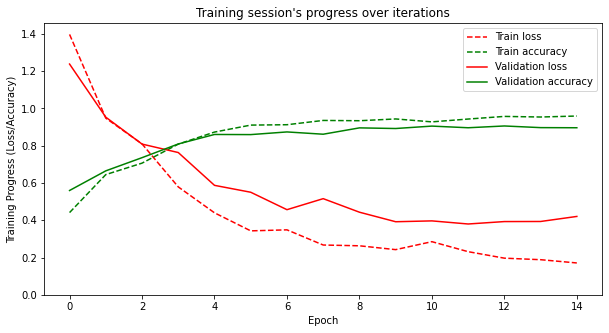

In [73]:
plot_training_graphs(history1)

In [75]:
# THe previous model without the validation data (trained on the full train set)


## GLOBAL SEED ##
np.random.seed(5)                                                   
tf.random.set_seed(5)

# TODO: make reproducible

NUM_EPOCHS = 15
BATCH_SZ = 64

model1 = keras.models.Sequential(
    [
     keras.layers.LSTM(units=90, input_shape=(n_timesteps, n_features),
                       bias_regularizer=keras.regularizers.l2(0.001), 
                       activity_regularizer=keras.regularizers.l2(0.001)),
     keras.layers.Dropout(rate=0.45),
     keras.layers.Dense(units=100, activation="relu"),
     keras.layers.Dense(units=n_classes, activation="softmax")
    ]
  )

# multiclass classification --> categorical crossentropy as the loss func
model1.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# fit the model
history1 = model1.fit(X_train, y_train, 
                    epochs=NUM_EPOCHS, 
                    batch_size=BATCH_SZ
                    #, validation_split=0.2
                    ) # , validation_data=(X_valid, y_valid)

# evaluate model on test set
print("\nEvaluation on test set:")
loss1, accuracy1 = model1.evaluate(X_test, y_test, batch_size=BATCH_SZ)

Epoch 1/15
115/115 [==============================] - 6s 31ms/step - loss: 1.3398 - accuracy: 0.4649
Epoch 2/15
115/115 [==============================] - 4s 32ms/step - loss: 0.8282 - accuracy: 0.6810
Epoch 3/15
115/115 [==============================] - 4s 31ms/step - loss: 0.6371 - accuracy: 0.7833
Epoch 4/15
115/115 [==============================] - 4s 31ms/step - loss: 0.5871 - accuracy: 0.8256
Epoch 5/15
115/115 [==============================] - 4s 32ms/step - loss: 0.3819 - accuracy: 0.8953
Epoch 6/15
115/115 [==============================] - 4s 31ms/step - loss: 0.3084 - accuracy: 0.9176
Epoch 7/15
115/115 [==============================] - 4s 31ms/step - loss: 0.2816 - accuracy: 0.9256
Epoch 8/15
115/115 [==============================] - 4s 31ms/step - loss: 0.3344 - accuracy: 0.9049
Epoch 9/15
115/115 [==============================] - 4s 31ms/step - loss: 0.3131 - accuracy: 0.9163
Epoch 10/15
115/115 [==============================] - 4s 32ms/step - loss: 0.2498 - accura

Bidirectional LSTM (now we can think that we would have the full 2.56s window of data to work with, so we can start from the end at real prediction time as well)

In [31]:
## GLOBAL SEED ##                                                   
np.random.seed(5)
tf.random.set_seed(5)

NUM_EPOCHS = 35
BATCH_SZ = 256

model_bi = keras.models.Sequential(
    [
     keras.layers.Bidirectional(
         keras.layers.LSTM(units=128, input_shape=(n_timesteps, n_features),
                       bias_regularizer=keras.regularizers.l2(0.01), 
                       activity_regularizer=keras.regularizers.l2(0.01))
     ),
     keras.layers.Dropout(rate=0.55),
     keras.layers.Dense(units=100, activation="relu"),
     keras.layers.Dropout(rate=0.1),
     keras.layers.Dense(units=n_classes, activation="softmax")
    ]
  )


# multiclass classification --> categorical crossentropy as the loss func
model_bi.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# fit the model
history_bi = model_bi.fit(X_train, y_train, 
                    epochs=NUM_EPOCHS, 
                    batch_size=BATCH_SZ, 
                    validation_split=0.2) # , validation_data=(X_valid, y_valid)

# evaluate model on test set
print("\nEvaluation on test set:")
loss_bi, accuracy_bi = model_bi.evaluate(X_test, y_test, batch_size=BATCH_SZ)

Epoch 1/35
23/23 [==============================] - 9s 212ms/step - loss: 3.9431 - accuracy: 0.4142 - val_loss: 3.6455 - val_accuracy: 0.5275
Epoch 2/35
23/23 [==============================] - 3s 125ms/step - loss: 3.4659 - accuracy: 0.5623 - val_loss: 3.4175 - val_accuracy: 0.5751
Epoch 3/35
23/23 [==============================] - 3s 121ms/step - loss: 3.1931 - accuracy: 0.6642 - val_loss: 3.1242 - val_accuracy: 0.6764
Epoch 4/35
23/23 [==============================] - 3s 119ms/step - loss: 2.8688 - accuracy: 0.7592 - val_loss: 2.9149 - val_accuracy: 0.7729
Epoch 5/35
23/23 [==============================] - 3s 119ms/step - loss: 2.6282 - accuracy: 0.8255 - val_loss: 2.7230 - val_accuracy: 0.8015
Epoch 6/35
23/23 [==============================] - 3s 119ms/step - loss: 2.4294 - accuracy: 0.8726 - val_loss: 2.4480 - val_accuracy: 0.8688
Epoch 7/35
23/23 [==============================] - 3s 123ms/step - loss: 2.2500 - accuracy: 0.9027 - val_loss: 2.3184 - val_accuracy: 0.8627
Epoch 

In [32]:
model_bi.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional (Bidirectiona  (None, 256)              141312    
 l)                                                              
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_2 (Dense)             (None, 100)               25700     
                                                                 
 dropout_2 (Dropout)         (None, 100)               0         
                                                                 
 dense_3 (Dense)             (None, 6)                 606       
                                                                 
Total params: 167,618
Trainable params: 167,618
Non-trainable params: 0
________________________________________________

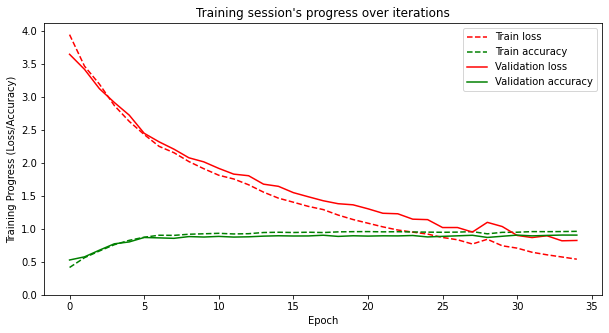

In [33]:
plot_training_graphs(history_bi)
# epoch numbering here is zero-based

In [34]:
# Experiment 1
if DO_EXPERIMENTS:

  NUM_TRIALS = 10

  EPOCHS = 15
  BATCH_SZ = 64

  test_acc_lstm = []
  test_acc_lstm_bi = []

  for trial in range(NUM_TRIALS):
    print("\nTrial:", trial)

    print("Unidirectional LSTM:")
    acc_lstm = build_and_test_lstm_model(X_train, y_train, X_test, y_test, 
                                                epochs=EPOCHS, batch_sz=BATCH_SZ, 
                                                seed=trial+1, verbose=0)
    test_acc_lstm.append(acc_lstm)


    print("Bidirectional LSTM:")
    acc_lstm_bi = build_and_test_bidirectional_lstm_model(X_train, y_train, X_test, y_test, 
                                                epochs=EPOCHS, batch_sz=BATCH_SZ, 
                                                seed=trial+1, verbose=0)
    test_acc_lstm_bi.append(acc_lstm_bi)


  print("LSTM test accuracies:")
  test_acc_lstm = np.array(test_acc_lstm)
  print(test_acc_lstm)
  print("test acc - mean, std:", test_acc_lstm.mean(), test_acc_lstm.std() )

  print("\n\nBidir. LSTM test accuracies:")
  test_acc_lstm_bi = np.array(test_acc_lstm_bi)
  print(test_acc_lstm_bi)
  print("test acc - mean, std:", test_acc_lstm_bi.mean(), test_acc_lstm_bi.std() )

In [35]:
# Experiment 2

if DO_EXPERIMENTS:
  NUM_TRIALS = 10

  EPOCHS = 22
  BATCH_SZ = 128

  test_acc_lstm2 = []
  test_acc_lstm_bi2 = []

  for trial in range(NUM_TRIALS):
    print("Trial:", trial)

    print("Unidirectional LSTM:")
    acc_lstm = build_and_test_lstm_model(X_train, y_train, X_test, y_test, 
                                                epochs=EPOCHS, batch_sz=BATCH_SZ, 
                                                seed=trial+1, verbose=0)
    test_acc_lstm2.append(acc_lstm)


    print("Bidirectional LSTM:")
    acc_lstm_bi = build_and_test_bidirectional_lstm_model(X_train, y_train, X_test, y_test, 
                                                epochs=EPOCHS, batch_sz=BATCH_SZ, 
                                                seed=trial+1, verbose=0)
    test_acc_lstm_bi2.append(acc_lstm_bi)


  print("LSTM test accuracies:")
  test_acc_lstm2 = np.array(test_acc_lstm2)
  print(test_acc_lstm2)
  print("test acc - mean, std:", test_acc_lstm2.mean(), test_acc_lstm2.std() )


  print("\n\nBidir. LSTM test accuracies:")
  test_acc_lstm_bi2 = np.array(test_acc_lstm_bi2)
  print(test_acc_lstm_bi2)
  print("test acc - mean, std:", test_acc_lstm_bi2.mean(), test_acc_lstm_bi2.std() )

In [36]:
# Experiment 3

if DO_EXPERIMENTS:
  NUM_TRIALS = 10

  EPOCHS = 40
  BATCH_SZ = 256

  test_acc_lstm3 = []
  test_acc_lstm_bi3 = []

  for trial in range(NUM_TRIALS):
    print("Trial:", trial)

    print("Unidirectional LSTM:")
    acc_lstm = build_and_test_lstm_model(X_train, y_train, X_test, y_test, 
                                                epochs=EPOCHS, batch_sz=BATCH_SZ, 
                                                seed=trial+1, verbose=0)
    test_acc_lstm3.append(acc_lstm)


    print("Bidirectional LSTM:")
    acc_lstm_bi = build_and_test_bidirectional_lstm_model(X_train, y_train, X_test, y_test, 
                                                epochs=EPOCHS, batch_sz=BATCH_SZ, 
                                                seed=trial+1, verbose=0)
    test_acc_lstm_bi3.append(acc_lstm_bi)


  print("LSTM test accuracies:")
  test_acc_lstm3 = np.array(test_acc_lstm3)
  print(test_acc_lstm3)
  print("test acc - mean, std:", test_acc_lstm3.mean(), test_acc_lstm3.std() )

  print("\n\nBidir. LSTM test accuracies:")
  test_acc_lstm_bi3 = np.array(test_acc_lstm_bi3)
  print(test_acc_lstm_bi3)
  print("test acc - mean, std:", test_acc_lstm_bi3.mean(), test_acc_lstm_bi3.std() )

Another model(s), with two stacked LSTMs.

In [55]:
# Another model, with two stacked LSTMs

## GLOBAL SEED ##                                                   
np.random.seed(123)
tf.random.set_seed(123)

NUM_EPOCHS = 100
BATCH_SZ = 1024

model_stacked = keras.models.Sequential(
    [
      keras.layers.Bidirectional(
        keras.layers.LSTM(units=32, input_shape=(n_timesteps, n_features),
                      bias_regularizer=keras.regularizers.l2(0.001), 
                      activity_regularizer=keras.regularizers.l2(0.001),
                      return_sequences=True)
        ),
      keras.layers.Dropout(rate=0.6),
      keras.layers.Bidirectional(
          keras.layers.LSTM(units=30,
                    bias_regularizer=keras.regularizers.l2(0.001), 
                    activity_regularizer=keras.regularizers.l2(0.001)
                    )
          ),
      keras.layers.Dropout(rate=0.5),
      keras.layers.Dense(units=50, activation="relu"),
      #keras.layers.Dropout(rate=0.1),
      keras.layers.Dense(units=n_classes, activation="softmax")
    ]
  )


# multiclass classification --> categorical crossentropy as the loss func
model_stacked.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# fit the model
history_stacked = model_stacked.fit(X_train, y_train, 
                    epochs=NUM_EPOCHS, 
                    batch_size=BATCH_SZ
                    , validation_split=0.2
                    ) # , validation_data=(X_valid, y_valid)

# evaluate model on test set
print("\nEvaluation on test set:")
loss_stacked, accuracy_stacked = model_stacked.evaluate(X_test, y_test, batch_size=BATCH_SZ)

# Reaches something like 89.8% test set accuracy

Epoch 1/100
6/6 [==============================] - 11s 550ms/step - loss: 1.9871 - accuracy: 0.3023 - val_loss: 1.8875 - val_accuracy: 0.3460
Epoch 2/100
6/6 [==============================] - 1s 205ms/step - loss: 1.8538 - accuracy: 0.3668 - val_loss: 1.7495 - val_accuracy: 0.2991
Epoch 3/100
6/6 [==============================] - 1s 203ms/step - loss: 1.7200 - accuracy: 0.3639 - val_loss: 1.6440 - val_accuracy: 0.3297
Epoch 4/100
6/6 [==============================] - 1s 206ms/step - loss: 1.6165 - accuracy: 0.4113 - val_loss: 1.5534 - val_accuracy: 0.4582
Epoch 5/100
6/6 [==============================] - 1s 204ms/step - loss: 1.5273 - accuracy: 0.4605 - val_loss: 1.4589 - val_accuracy: 0.4663
Epoch 6/100
6/6 [==============================] - 1s 223ms/step - loss: 1.4404 - accuracy: 0.4656 - val_loss: 1.3818 - val_accuracy: 0.5024
Epoch 7/100
6/6 [==============================] - 1s 208ms/step - loss: 1.3645 - accuracy: 0.5106 - val_loss: 1.3065 - val_accuracy: 0.5629
Epoch 8/100


No major differences between the performance of the tried models. Let's continue with the first model that was trained on the full train set (without train-val split), i.e. "model1".




These models learns quite quickly to ~88-91 % accuracy level on test set (some variability due to randomness + exact parameters). There is not tremendously much difference between the models.

The original paper (*Davide Anguita, Alessandro Ghio, Luca Oneto, Xavier Parra and Jorge L. Reyes-Ortiz. Human Activity Recognition on Smartphones using a Multiclass Hardware-Friendly Support Vector Machine. International Workshop of Ambient Assisted Living (IWAAL 2012). Vitoria-Gasteiz, Spain. Dec 2012*), accessible e.g. [here](https://upcommons.upc.edu/bitstream/handle/2117/101769/IWAAL2012.pdf), reported test set precision of 89.3 %. So the results seem quite okay, given that we basically pretty much only threw the data as it was into the model.

Seems also that the valid set share similarities with train and is somewhat different from test. I think this is because we have data from same persons in train and valid (and maybe even some overlapping windows, because we did not carefully split the data - the given dataset didn't have the detailed person ids etc.. However, I think there is a newer(?) dataset available that does have these additional details --> could be more intelligently to construct the valid set)






### Check confusion matrix

In [64]:
y_idx_to_label

{0: 'WALKING',
 1: 'WALKING_UPSTAIRS',
 2: 'WALKING_DOWNSTAIRS',
 3: 'SITTING',
 4: 'STANDING',
 5: 'LAYING'}

In [66]:
CLASS_LABELS = [y_idx_to_label[i] for i in range(6)]
CLASS_LABELS

['WALKING',
 'WALKING_UPSTAIRS',
 'WALKING_DOWNSTAIRS',
 'SITTING',
 'STANDING',
 'LAYING']

In [76]:
# How to predict single example
#CLASS_LABELS = ['WALKING', 'WALKING_UPSTAIRS', 'WALKING_DOWNSTAIRS', 'SITTING', 'STANDING', 'LAYING']

test_sample_idx = 333
print(f"Prediction:{np.argmax(model1.predict(X_test[test_sample_idx, :, :].reshape(1, 128, 9)))}, \
true:{np.argmax(y_test[test_sample_idx])}")

Prediction:3, true:3


In [77]:
# Batch predict
predictions = model1.predict(X_test)

# these use the indices
y_true = np.argmax(y_test, axis=1)
y_pred = np.argmax(predictions, axis=1)


In [78]:
# accuracy sanity check
(y_true == y_pred).sum() / len(y_true)

0.9083814048184594

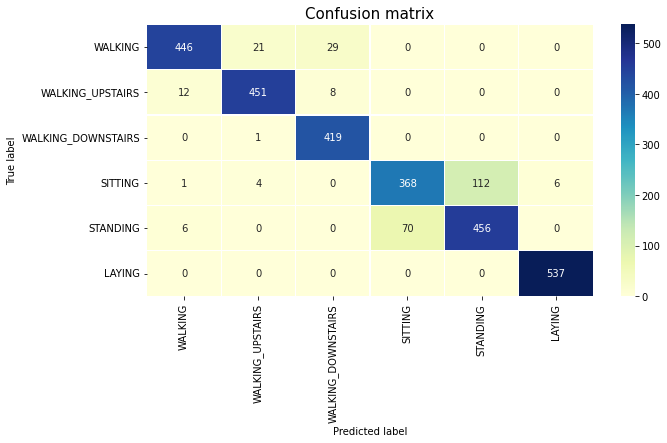

In [83]:
# Confusion matrix
confusion_mat = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(10,5))
sns.heatmap(confusion_mat, 
            xticklabels=CLASS_LABELS, yticklabels=CLASS_LABELS, 
            annot=True, linewidths=0.1, fmt='d', cmap='YlGnBu')

plt.title("Confusion matrix", fontsize=15)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

The model has some problems in separating SITTING and STANDING activities from one another.

Okay, fairly straighforward, especially as the required preprocessing (signal processing, windowing etc.) was basically done for the input data already.

### Hyperparameter tuning (OMITTED)